In [12]:
# Loading Libraries, Remember to run this cell!
library(tidyverse)
library(repr)
library(tidymodels)

options(repr.matrix.max.rows = 6)

In [19]:
# Loading in the data
# Data read from https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS
player_stats <- read_csv("player_stats.csv")
colnames(player_stats) <- make.names(colnames(player_stats))
#   Remove unnecessary columns
player_stats_clean <- player_stats %>%
    select(Age:Peak.Elo.Rating, -Retired, -Country, -Wikipedia, -Current.Rank,-Name, -Seasons, -Prize.Money, -Active, -Favorite.Surface, -Best.Elo.Rank) %>%
    na.omit() %>%
#   Mutating columns with as_factor()
    mutate(Dominate.Hand = as_factor(Plays)) %>%
    select(-Plays) %>%
    mutate(Backhand = as_factor(Backhand)) %>%
#   Cleaning up columns with string values
    mutate(Height = strtoi(str_remove(Height, " cm"))) %>%
    mutate(Year.Experience = 2020 - Turned.Pro) %>%
    mutate(Age = strtoi(substr(Age, 0, 2))) %>%
    mutate(Current.Elo.Rank = strtoi(substr(Current.Elo.Rank, 0, nchar(Current.Elo.Rank)-7))) 

player_stats
player_stats_clean

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  .default = col_character(),
  X1 = col_double(),
  `Turned Pro` = col_double(),
  Seasons = col_double(),
  Titles = col_double(),
  `Best Season` = col_double(),
  Retired = col_double(),
  Masters = col_double(),
  `Grand Slams` = col_double(),
  `Davis Cups` = col_double(),
  `Team Cups` = col_double(),
  Olympics = col_double(),
  `Weeks at No. 1` = col_double(),
  `Tour Finals` = col_double()
)

See spec(...) for full column specifications.



X1,Age,Country,Plays,Wikipedia,Current.Rank,Best.Rank,Name,Backhand,Prize.Money,⋯,Facebook,Twitter,Nicknames,Grand.Slams,Davis.Cups,Web.Site,Team.Cups,Olympics,Weeks.at.No..1,Tour.Finals
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0,26 (25-04-1993),Brazil,Right-handed,Wikipedia,378 (97),363 (04-11-2019),Oscar Jose Gutierrez,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,18 (22-12-2001),United Kingdom,Left-handed,Wikipedia,326 (119),316 (14-10-2019),Jack Draper,Two-handed,"$59,040",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,32 (03-11-1987),Slovakia,Right-handed,Wikipedia,178 (280),44 (14-01-2013),Lukas Lacko,Two-handed,"US$3,261,567",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
497,23 (14-03-1996),Netherlands,Left-handed,Wikipedia,495 (60),342 (05-08-2019),Gijs Brouwer,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
498,24 (17-05-1995),Ukraine,NA,Wikipedia,419 (81),419 (20-01-2020),Vladyslav Orlov,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
499,22 (26-03-1997),Tunisia,Left-handed,Wikipedia,451 (69),408 (24-12-2018),Aziz Dougaz,Two-handed,"$61,984",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


Age,Best.Rank,Backhand,Height,Turned.Pro,Current.Elo.Rank,Peak.Elo.Rating,Dominate.Hand,Year.Experience
<int>,<chr>,<fct>,<int>,<dbl>,<int>,<chr>,<fct>,<dbl>
32,44 (14-01-2013),Two-handed,185,2005,144,1886 (06-02-2012),Right-handed,15
27,17 (11-01-2016),Two-handed,193,2008,100,2037 (01-02-2016),Right-handed,12
31,3 (13-08-2018),Two-handed,198,2005,4,2329 (14-09-2009),Right-handed,15
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
29,3 (21-11-2016),Two-handed,196,2008,21,2269 (11-07-2016),Right-handed,12
34,8 (21-08-2006),Two-handed,183,2003,74,2098 (18-02-2008),Right-handed,17
26,4 (06-11-2017),One-handed,185,2011,6,2211 (18-11-2019),Right-handed,9


In [22]:
set.seed(1234)
# Making the training and testing splits for each of the predictions
backhand_split <- initial_split(player_stats_clean, prop = .6, strata = Backhand)
backhand_training <- training(backhand_split)
backhand_testing <- testing(backhand_split)

hand_split <- initial_split(player_stats_clean, prop = .6, strata = Dominate.Hand)
hand_training <- training(hand_split)
hand_testing <- testing(hand_split)

# backhand_training
# backhand_testing
# hand_training
# hand_testing

In [23]:
set.seed(1234)
# Creating the Recipes
backhand_recipe <- recipe(Backhand ~ Current.Elo.Rank + Year.Experience, data = backhand_training) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

hand_recipe <- recipe(Dominate.Hand ~ Current.Elo.Rank + Year.Experience, data = hand_training) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

# backhand_recipe
# hand_recipe

In [24]:
set.seed(1234)

# Creating the vfolds
backhand_vfold <- vfold_cv(backhand_training, v = 5, strata = Backhand)
hand_vfold <- vfold_cv(hand_training, v = 5, strata = Dominate.Hand)

In [25]:
set.seed(1234)
# Making the tune model to choose the best value of k
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
        set_engine("kknn") %>%
        set_mode("classification")

In [26]:
set.seed(1234)
# Collecting metrics to determine best value of k
backhand_results <- workflow() %>%
    add_recipe(backhand_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = backhand_vfold, grid = 10) %>%
    collect_metrics

hand_results <- workflow() %>%
    add_recipe(hand_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = hand_vfold, grid = 10) %>%
    collect_metrics

backhand_results
hand_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.7609091,5,0.04580772,Model01
2,roc_auc,binary,0.5733796,5,0.04697363,Model01
3,accuracy,binary,0.7406061,5,0.03224960,Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
13,roc_auc,binary,0.6157407,5,0.06951771,Model09
14,accuracy,binary,0.7972727,5,0.01249793,Model10
14,roc_auc,binary,0.6398148,5,0.04958569,Model10


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6924242,5,0.08505926,Model1
1,roc_auc,binary,0.4055556,5,0.04937886,Model1
3,accuracy,binary,0.8157576,5,0.02782934,Model2
⋮,⋮,⋮,⋮,⋮,⋮,⋮
12,roc_auc,binary,0.6422222,5,0.11349661,Model8
14,accuracy,binary,0.8539394,5,0.01900655,Model9
14,roc_auc,binary,0.5744444,5,0.13749972,Model9


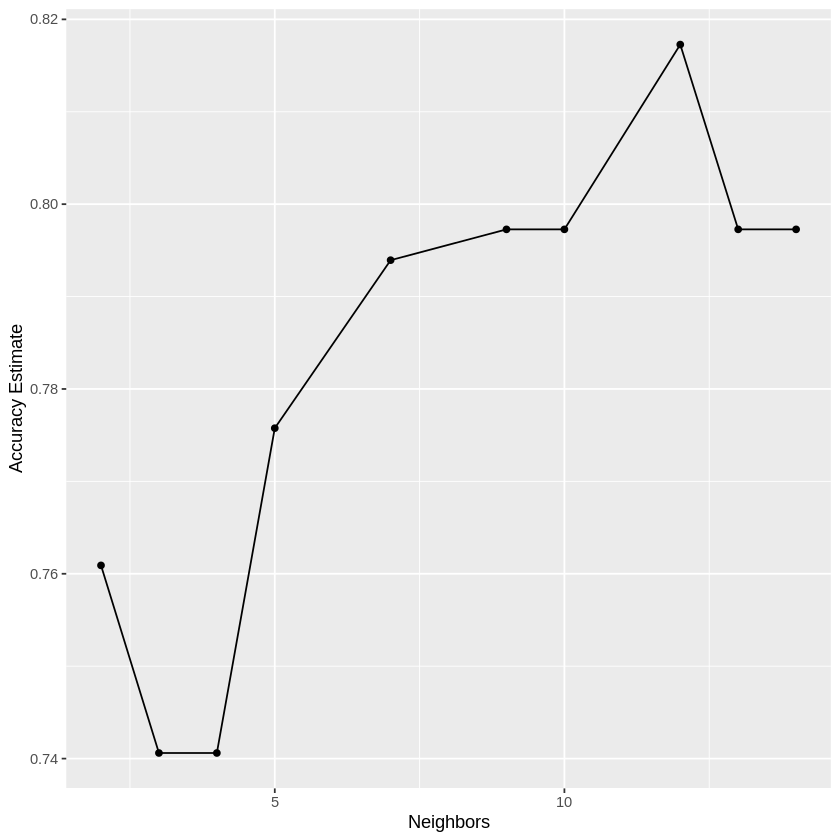

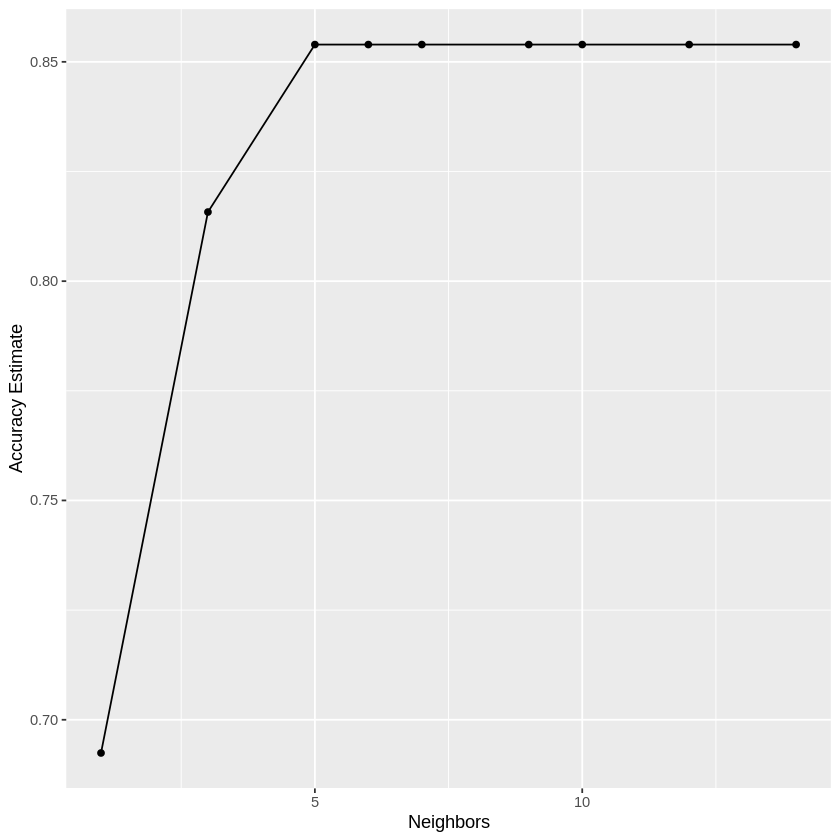

In [27]:
accuracies <- backhand_results %>%
  filter(.metric == "accuracy")

backhand_accuracy_vs_k <-ggplot(accuracies,aes(x = neighbors, y = mean)) +
  geom_point()+
  geom_line()+
  labs(x = "Neighbors", y = "Accuracy Estimate")
backhand_accuracy_vs_k

accuracies <- hand_results %>%
  filter(.metric == "accuracy")

hand_accuracy_vs_k <-ggplot(accuracies,aes(x = neighbors, y = mean)) +
  geom_point()+
  geom_line()+
  labs(x = "Neighbors", y = "Accuracy Estimate")
hand_accuracy_vs_k